In [1]:
# Utilities
from time import time
import itertools
import warnings

# Numerical calculation
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

import seaborn as sns

# Sequential Modeling
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Embedding, LSTM, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.sequence import pad_sequences

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve


Using TensorFlow backend.


In [0]:
# Configure for any default setting of any library
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

In [0]:
#Loading the dataset

In [0]:
# Load IMDB Data
vocab_size = 10000 #vocab size

# save np.load
old = np.load

# modify the default parameters of np.load to allow_pickle to avoid the following error:
# ValueError: Object arrays cannot be loaded when allow_pickle=False
np.load = lambda *a,**k: old(*a,allow_pickle=True)

# call load_data with allow_pickle implicitly set to true
imdb_data = imdb.load_data(num_words=vocab_size)

# restore np.load for future normal usage and delete the old
np.load = old
del(old)

In [0]:
#Train test split

train_data  (25000,)
train_labels  (25000,)
__________________________________________________
test_data  (25000,)
test_labels  (25000,)
__________________________________________________
Minimum value of a word index : 1
Maximum value of a word index : 9999
Maximum number of words of review in train : 2494
Minimum number of words of review in train : 11
Maximum number of words of review in test  : 2315
Minimum number of words of review in test  : 7


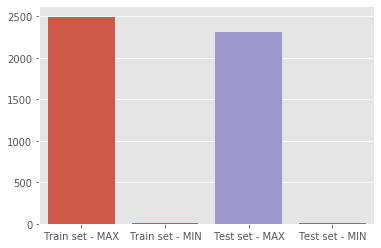

In [6]:
#load dataset as a list of ints
(train_data, train_labels), (test_data, test_labels) = imdb_data

print("train_data ", train_data.shape)
print("train_labels ", train_labels.shape)
print("_"*50)
print("test_data ", test_data.shape)
print("test_labels ", test_labels.shape)
print("_"*50)
print("Minimum value of a word index :", min([min(sequence) for sequence in train_data]))
print("Maximum value of a word index :", max([max(sequence) for sequence in train_data]))
train_len = [len(sequence) for sequence in train_data]
test_len = [len(sequence) for sequence in test_data]
print("Maximum number of words of review in train :", max(train_len))
print("Minimum number of words of review in train :", min(train_len))
print("Maximum number of words of review in test  :", max(test_len))
print("Minimum number of words of review in test  :", min(test_len))

# Visualize the length of max and min length reviews in both training and test sets
sns.barplot(x=['Train set - MAX','Train set - MIN','Test set - MAX','Test set - MIN'], 
            y=[max(train_len),min(train_len),max(test_len),min(test_len)])

In [0]:
#sentiment types

[0 1]


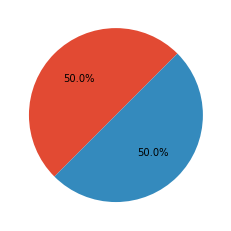

In [8]:
# The unique sentiments as target column
unique, counts = np.unique(np.concatenate((train_labels, test_labels)), return_counts=True)
print(unique)
sentiments = {1: 'Positive', 0: 'Negative'}

# Visualize the propertion of Positive and Negative reviewes in the original dataset
_ = plt.pie(counts, autopct='%1.1f%%', startangle=45)

In [0]:
#Interpete the actual Reviews

In [10]:
# Reverse from integers to words using the DICTIONARY (given by keras...need to do nothing to create it)
def interprete_review(sequence):
    id_to_word = dict([(value, key) for (key, value) in imdb.get_word_index().items()])
    decoded_review = ' '.join([id_to_word.get(idx-3, '?') for idx in sequence])
    print(decoded_review)
    
review_id1 = np.random.choice(train_len)
interprete_review(train_data[review_id1])
print('\nThe sentiment for the above review is:', sentiments.get(train_labels[review_id1]))
print("_"*125)
review_id2 = np.random.choice(test_len)
interprete_review(test_data[review_id2])
print('\nThe sentiment for the above review is:', sentiments.get(test_labels[review_id2]))

? sorry but i will spoil both the plot line and the ending for you in hopes of avoiding a holiday fiasco like the one that i now face the father dies and the mother asks santa in a letter to bring him back to the family for christmas and santa does dad is ? happy healthy and totally unaware of the fact that he had died all ends ? sweet br br but as a parent who recently watched my five year old lose his best ? friend it was a horror flick now my son is convinced that all he has to do to bring his buddy back is to ask santa do not ? the ? of a young heart no amount of ? will convince him that it was only a movie and that his dog is not coming back for christmas it has been heart breaking to watch his joy only to know that christmas eve he will have to face his loss ? br br shame on you on behalf of all the ? that have lost a loved one recently it is hard enough to deal with the loss one time for a child but there are some wishes that we shouldn't even portray as a possibility

The senti

In [0]:
#vectorize input data
#Both train_data and test_data are in the form of 1D list of integers. They need to be converted into binary matrix in order to feed them into NN model. Besides all the reviews are NOT of same length. So we are using pad_sequences from keras to make all the reviews of same size by padding 0's before the sequence.

#We're going to pad them to make them of equal size of 300 as per the question instead of considering the max length for padding to be 2494 which is the word count of highest length review.

#We'll also analyze how much portion of original data we're trimming off by considering 300 as the maxlen.

In [12]:
maxlen = 1500  #number of word used from each review
# maxlen = max([len(sequence) for sequence in np.concatenate([train_data, test_data])])

#make all sequences of the same length
x_train = pad_sequences(train_data, maxlen=maxlen)
x_test =  pad_sequences(test_data, maxlen=maxlen)

y_train = train_labels
y_test = test_labels

print("x_train :", x_train.shape)
print("x_test  :", x_test.shape)

x_train : (25000, 1500)
x_test  : (25000, 1500)


In [13]:
# Visualize any random review after padding
x_train[np.random.randint(0,len(train_data)-1)]

array([  0,   0,   0, ...,  77, 128, 343], dtype=int32)

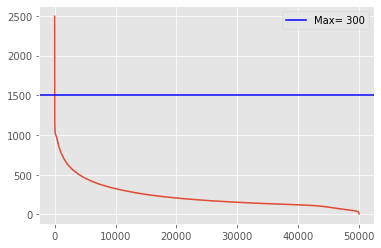

In [14]:
# Plot the max word count of all 50,000 reviews
imdb_len = [len(sequence) for sequence in np.concatenate((train_data,test_data))]
plt.plot(np.sort(imdb_len)[::-1])
plt.axhline(maxlen, color='b', label='Max= 300')
plt.legend()

In [15]:
print('Trimming off %.2f%% of data by setting 300 as maxlen' % (len([i for i in imdb_len if i > maxlen]) / len(imdb_len) * 100))

Trimming off 0.02% of data by setting 300 as maxlen


In [0]:
Observations:

- From the above figure and the calculation it is found out that by setting maxlen to 300, we're trimming off almost $\frac{1}{5}^{th}$ of original review data
Build Keras Sequential Model
We can think of the Embedding layer as a dicionary that maps a index assigned to a word to a word vector. This layer is very flexible and can be used in a few ways:

The embedding layer can be used at the start of a larger deep learning model.
Also we could load pre-train word embeddings into the embedding layer when we create our model.
Use the embedding layer to train our own word2vec models.
The keras embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unqiue intger number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn LabelEncoder.

Generic Methods
Let's write some generic method to plot some useful curves such as validation curves, precision-recall curves and print the classification summary.

In [0]:
# Generic method to plot the VALIDATION curves
def plot_validation_curve(history, metrics):
    plt.clf()
    history_dict = history.history
    f, ax = plt.subplots(1, len(metrics), figsize=(16,6))
    for i, metric in enumerate(metrics):
        metric_values = history_dict[metric]
        val_metric_values = history_dict['val_' + metric]
        epochs = range(1, (len(history_dict[metric]) + 1))
        ax[i].plot(epochs, metric_values, 'bo:', label='Training ' + metric)
        ax[i].plot(epochs, val_metric_values, 'go-', label='Validation ' + metric)
        ax[i].set_title('Training and Validation ' + ('Accuracy' if metric=='acc' else 'Loss'))
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Accuracy' if metric=='acc' else 'Loss')
        ax[i].legend()

In [0]:
# Generic method to plot Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

In [0]:
# Generic method to print the classification report
def classification_summary(y_test, y_pred, y_proba):
    print('\033[1mTesting accuracy:\033[0m %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('_'*80)
    print('\033[1mConfusion matrix:\033[0m\n %s' % (confusion_matrix(y_test, y_pred)))
    print('_'*80)
    print('\033[1mClassification report:\033[0m\n %s' % (classification_report(y_test, y_pred)))
    print('_'*80)
    print('\033[1mPrecision-Recall curve\033[10m')
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    plot_prec_recall_vs_thresh(precision, recall, thresholds)

In [0]:

Let's try for different flavors of Neural Networks to observe their performances with sequential textual data.

Phase I - With Simple Artificial Neural Network (ANN)
The first deep learning model that we are going to develop is a simple deep neural network.

In [20]:
embedding_dim = 300
# Build the network
ann = Sequential()
ann.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
ann.add(Flatten())
ann.add(Dense(1, activation='sigmoid'))
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 300)         3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 450000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 450001    
Total params: 3,450,001
Trainable params: 3,450,001
Non-trainable params: 0
_________________________________________________________________


In [25]:

# Train the model
epochs = 5
batches = 512
start = time()
history = ann.fit(x_train, y_train, epochs=epochs, batch_size=batches, validation_split=0.2)
print('Time spent: %.2f sec' % (time()-start))




Train on 20000 samples, validate on 5000 samples
Epoch 1/5





20000/20000 [==============================] - 56s 3ms/step - loss: 1.0378 - acc: 0.5181 - val_loss: 0.6606 - val_acc: 0.5590
Epoch 2/5
20000/20000 [==============================] - 54s 3ms/step - loss: 0.4865 - acc: 0.8188 - val_loss: 0.3693 - val_acc: 0.8574
Epoch 3/5
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2385 - acc: 0.9194 - val_loss: 0.2925 - val_acc: 0.8814
Epoch 4/5
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1466 - acc: 0.9583 - val_loss: 0.2771 - val_acc: 0.8854
Epoch 5/5
20000/20000 [==============================] - 54s 3ms/step - loss: 0.0913 - acc: 0.9834 - val_loss: 0.2751 - val_acc: 0.8858
Time spent: 272.85 sec


<Figure size 432x288 with 0 Axes>

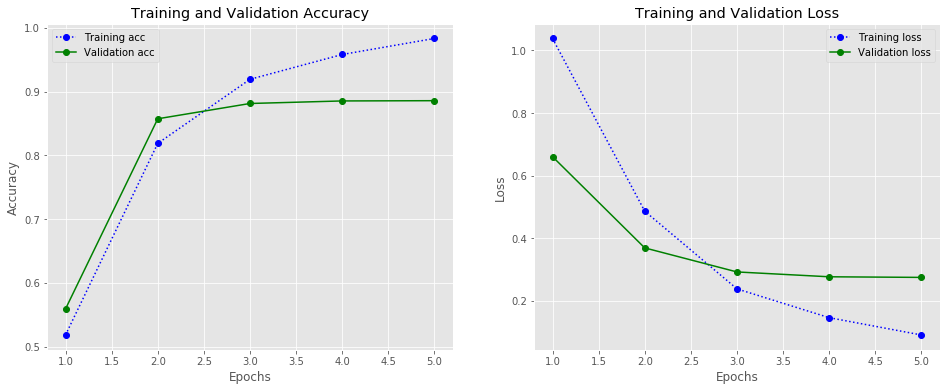

In [26]:
# VALIDATION ACCURACY and LOSS Curve
plot_validation_curve(history, ['acc','loss'])

In [27]:
# Find Loss and Accuracy of test set
loss, acc = ann.evaluate(x_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

25000/25000 [==============================] - 28s 1ms/step
Test Loss: 0.2794 and Accuracy: 88.30%


In [0]:
#Analyze Classification Summary

y_pred = ann.predict_classes(x_test)
y_proba = ann.predict_proba(x_test)
classification_summary(y_test, y_pred, y_proba)

In [0]:

Observations:

ANN seems to be working good 88.3% test score.
However, we can clearly see the differences for loss and accuracy between the training and validation sets. This indicates that the model is overfitted.
Phase II - With Convolutional Neural Network (CNN)
Convolutional neural network is a type of network that is primarily used for 2D data classification, such as images. These networks also have been found to be working well with text data as well. Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data.
Let's create a simple convolutional neural network with 1 convolutional layer and 1 pooling layer.

In [29]:
# Build the network
cnn = Sequential()
cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
cnn.add(Dense(250, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 300)         3000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1500, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1500, 32)          28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 750, 32)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 750, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 24000)             0         
___

In [30]:
# Train the model
epochs = 5
batches = 512
start = time()
history = cnn.fit(x_train, y_train, epochs=epochs, batch_size=batches, validation_split=0.2)
print('Time spent: %.2f sec' % (time()-start))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 399s 20ms/step - loss: 0.7420 - acc: 0.5045 - val_loss: 0.6876 - val_acc: 0.4938
Epoch 2/5
20000/20000 [==============================] - 399s 20ms/step - loss: 0.5794 - acc: 0.6400 - val_loss: 0.3769 - val_acc: 0.8432
Epoch 3/5
20000/20000 [==============================] - 403s 20ms/step - loss: 0.2687 - acc: 0.8922 - val_loss: 0.3317 - val_acc: 0.8638
Epoch 4/5
20000/20000 [==============================] - 399s 20ms/step - loss: 0.1630 - acc: 0.9405 - val_loss: 0.2934 - val_acc: 0.8850
Epoch 5/5
20000/20000 [==============================] - 397s 20ms/step - loss: 0.1084 - acc: 0.9639 - val_loss: 0.3189 - val_acc: 0.8850
Time spent: 1996.93 sec


<Figure size 432x288 with 0 Axes>

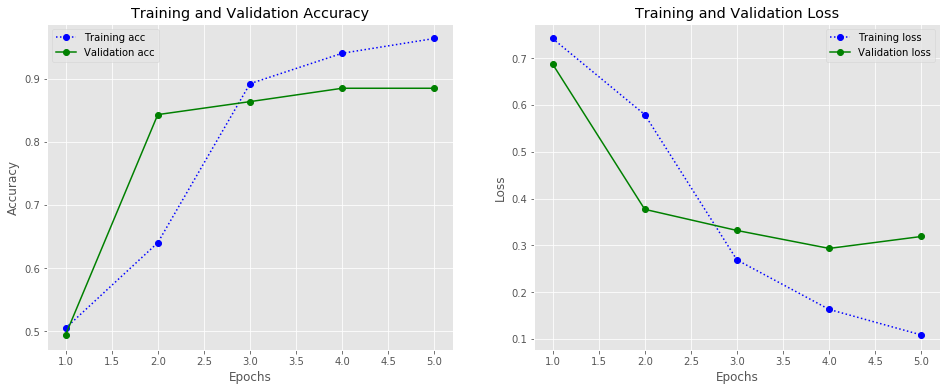

In [31]:
# VALIDATION ACCURACY and LOSS Curve
plot_validation_curve(history, ['acc','loss'])

In [32]:
# Find Loss and Accuracy of test set
loss, acc = cnn.evaluate(x_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

25000/25000 [==============================] - 109s 4ms/step
Test Loss: 0.3521 and Accuracy: 86.91%


Testing accuracy: 86.91%
________________________________________________________________________________
Confusion matrix:
 [[11288  1212]
 [ 2061 10439]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87     12500
           1       0.90      0.84      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

________________________________________________________________________________
Precision-Recall curve


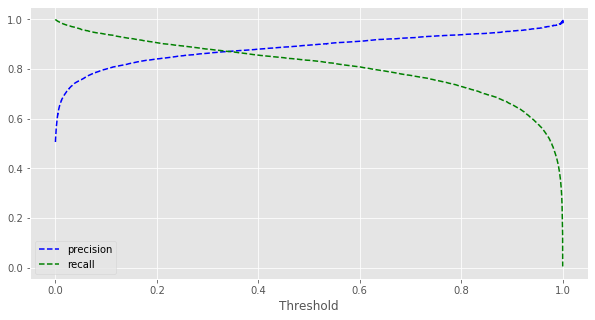

In [33]:
y_pred = cnn.predict_classes(x_test)
y_proba = cnn.predict_proba(x_test)
classification_summary(y_test, y_pred, y_proba)

In [0]:
Observations:

CNN seems to be working badly though the test score is close to ANN.
The significant deviation of accuracy and loss curves of validation set from test set indicates it is deviating from convergence.
Phase III - With Recurrent Neural Network (LSTM)
Recurrent neural network is a type of neural networks that is proven to work well with sequence data. Since text is actually a sequence of words, a recurrent neural network is an automatic choice to solve text-related problems. In this section, we will use an LSTM (Long Short Term Memory network) which is a variant of RNN, to solve sentiment classification problem.

In [22]:
# Build the network
lstm = Sequential()
lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
lstm.add(Dropout(0.2))
lstm.add(LSTM(128, activation='tanh', dropout=0.2,
               kernel_constraint=unit_norm(),
               recurrent_constraint=unit_norm(),
               bias_constraint=unit_norm()))
lstm.add(Dense(150, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 300)         3000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1500, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 150)               19350     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Tota

In [23]:
# Train the model
epochs =5
batches = 128
start = time()
history = lstm.fit(x_train, y_train, epochs=epochs, batch_size=batches, validation_split=0.2)
print('Time spent: %.2f sec' % (time()-start))




Train on 20000 samples, validate on 5000 samples
Epoch 1/5





20000/20000 [==============================] - 1862s 93ms/step - loss: 0.4647 - acc: 0.7650 - val_loss: 0.3832 - val_acc: 0.8280
Epoch 2/5
20000/20000 [==============================] - 1851s 93ms/step - loss: 0.2597 - acc: 0.8995 - val_loss: 0.3345 - val_acc: 0.8760
Epoch 3/5
20000/20000 [==============================] - 1847s 92ms/step - loss: 0.1901 - acc: 0.9303 - val_loss: 0.3579 - val_acc: 0.8444
Epoch 4/5
20000/20000 [==============================] - 1875s 94ms/step - loss: 0.2103 - acc: 0.9174 - val_loss: 0.4285 - val_acc: 0.8102
Epoch 5/5
20000/20000 [==============================] - 1911s 96ms/step - loss: 0.5370 - acc: 0.7607 - val_loss: 0.5998 - val_acc: 0.7420
Time spent: 9347.37 sec


<Figure size 432x288 with 0 Axes>

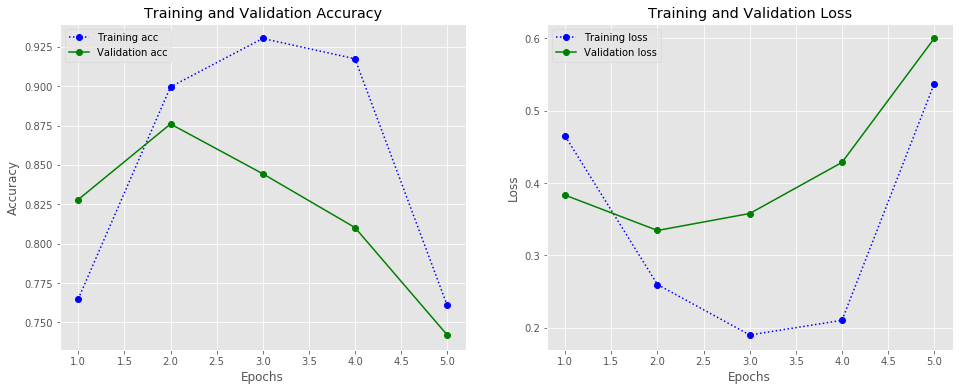

In [24]:
# VALIDATION ACCURACY and LOSS Curve
plot_validation_curve(history, ['acc','loss'])

In [25]:
# Find Loss and Accuracy of test set
loss, acc = lstm.evaluate(x_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

25000/25000 [==============================] - 502s 20ms/step
Test Loss: 0.6150 and Accuracy: 72.74%


Testing accuracy: 72.74%
________________________________________________________________________________
Confusion matrix:
 [[11817   683]
 [ 6132  6368]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.95      0.78     12500
           1       0.90      0.51      0.65     12500

    accuracy                           0.73     25000
   macro avg       0.78      0.73      0.71     25000
weighted avg       0.78      0.73      0.71     25000

________________________________________________________________________________
Precision-Recall curve


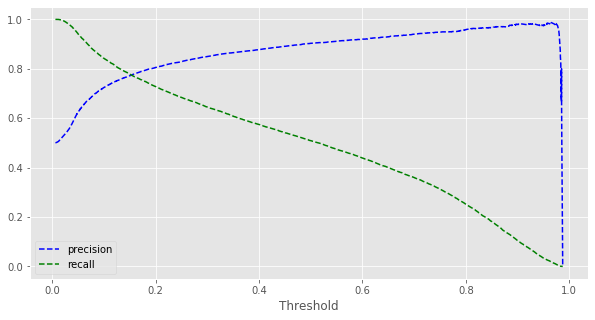

In [26]:
y_pred = lstm.predict_classes(x_test)
y_proba = lstm.predict_proba(x_test)
classification_summary(y_test, y_pred, y_proba)

In [0]:
Observations:

The output shows that the difference between the accuracy and loss values for training and validation sets are much smaller compared to the simple neural network and CNN.
Even though the test score is slightly less than the other two networks, just because this model is not overfitted, we can conclude, that for our problem, RNN is the best algorithm.

In [0]:
Single Instance Prediction
Let's pull a single review from the imdb dataset and predict it's sentiment. Also predict the sentiment of a custom review.

In [29]:
# Predict for a random pre-defined review from IMDB dataset
review_id = np.random.choice(test_len)
interprete_review(test_data[review_id])
print('\nThe \033[1mACTUAL\033[0m sentiment    :\033[1m' + sentiments.get(test_labels[review_id]) + '\033[0m')
prediction = lstm.predict_classes(pad_sequences([test_data[review_id]], maxlen=maxlen))
print('\nThe \033[1mPREDICTED\033[0m sentiment :\033[1m' + sentiments.get(prediction[0][0]) + '\033[0m')


? young ? who doesn't associate with women her own age and is eyed by gentleman from the retirement set invites an apparently mute young man into her apartment on a rainy day nervous and overly polite to hide her own sexual ? she is most pleased when the boy makes himself to home in her guest bedroom but not so happy when he begins ? out the window at night sandy dennis is not a hapless actress but why she was attracted to these sad sack roles i guess we'll never know based on a book by richard miles and about as far removed from a commercial drama as one could get this lurid material not only attracted dennis but also director robert altman whose work is static at best the narrative seems almost a sex ? of the collector a tag which may have sold the film rights but which doesn't turn out to be a good idea ? even the film's best sequence dennis shopping for a prostitute to satisfy her prisoner doesn't quite come off with sandy acting both ill and ? whose idea was this plan michael burn

In [0]:
# Predict for a custom review not present in the IMDB dataset
review = '''This Movie should only be watched if you want to punish yourself by sitting through 3 hours of torture.
            Bland movie, extremely slow, boring, monotonous with weak and predictable story with dose of overacting'''
word_dict = imdb.get_word_index()
words = review.split()
review = []
for word in words:
    if word.lower() not in word_dict:
        review.append(2)
    else:
        review.append(word_dict[word.lower()] + 3)

In [0]:
prediction = lstm.predict_classes(pad_sequences([review], maxlen=maxlen))
print('\nThe PREDICTED sentiment for this custom review:\033[1m', sentiments.get(prediction[0][0]))

In [0]:
Observation:

- As we can see the model is predicting pretty well for pre-defined reviews as well as for any custom review that is not in IMDB dataset, even if it is sarcastic.
Retrive the output of each layer in keras for a given single test sample from the trained model you built
Let's create a generic method to print the name, size and output of each layer in Keras model.

In [0]:
def layer_outs_for_single_instance(model, instance):
    outputs = [layer.output for layer in model.layers]                  # all layer outputs
    function = K.function([model.input, K.learning_phase()], outputs)   # evaluation function
    
    if instance.any():
        layer_outs = function([np.array([instance,]), 1.])
        print('_'*75)
        for idx, out in enumerate(layer_outs):
            print('\033[1mLayer# :', idx + 1)
            print('\033[1mName   :', model.layers[idx].name)
            print('\033[1mShape  : ' + str(out.shape) + '\033[0m')
            print(out)
            print('_'*75)

In [0]:

NOTE:
K.function creates TensorFlow tensor functions which are later used to get the output from the symbolic graph given the input. The model builds the predict function using K.function.
Now K.learning_phase() is required as an input as many Keras layers like Dropout/Batchnomalization depend on it to change behavior during training and test time.

More reference from the following link: The output of an intermediate layer in Keras

In [35]:
layer_outs_for_single_instance(lstm, x_test[np.random.choice(test_len)])

___________________________________________________________________________
Layer# : 1
Name   : embedding_2
Shape  : (1, 1500, 300)
[[[-0.0651807   0.02915601 -0.0618888  ...  0.01088229 -0.00417453
   -0.03996328]
  [-0.0651807   0.02915601 -0.0618888  ...  0.01088229 -0.00417453
   -0.03996328]
  [-0.0651807   0.02915601 -0.0618888  ...  0.01088229 -0.00417453
   -0.03996328]
  ...
  [ 0.02645377 -0.02455208 -0.04241206 ... -0.02459168  0.01415329
    0.01798057]
  [ 0.0005875  -0.03495087 -0.03419924 ...  0.01218858  0.02598161
   -0.02505295]
  [-0.0318664  -0.01281158  0.00099091 ... -0.00480783 -0.01506805
   -0.03064739]]]
___________________________________________________________________________
Layer# : 2
Name   : dropout_1
Shape  : (1, 1500, 300)
[[[-0.08147588  0.03644501 -0.077361   ...  0.         -0.00521816
   -0.04995409]
  [-0.          0.         -0.077361   ...  0.         -0.
   -0.04995409]
  [-0.08147588  0.         -0.077361   ...  0.         -0.
   -0.04995409]